# Telco Customer Churn Prediction

## 1. Import Libraries


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline



## 2. Load and Inspect Data


In [2]:

# Load the datasets
train_df = pd.read_csv('C:/Users/HP/Desktop/telco-customer-churn/data/processed/train_processed.csv')
val_df = pd.read_csv('C:/Users/HP/Desktop/telco-customer-churn/data/processed/validation_processed.csv')
test_df = pd.read_csv('C:/Users/HP/Desktop/telco-customer-churn/data/processed/test_processed.csv')


In [3]:

# Display basic information about the datasets
print(train_df.info())
print(val_df.info())
print(test_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seniorcitizen     4218 non-null   int64  
 1   partner           4218 non-null   object 
 2   dependents        4218 non-null   object 
 3   tenure            4218 non-null   int64  
 4   multiplelines     4218 non-null   object 
 5   internetservice   4218 non-null   object 
 6   onlinesecurity    4218 non-null   object 
 7   onlinebackup      4218 non-null   object 
 8   deviceprotection  4218 non-null   object 
 9   techsupport       4218 non-null   object 
 10  streamingtv       4218 non-null   object 
 11  streamingmovies   4218 non-null   object 
 12  contract          4218 non-null   object 
 13  paperlessbilling  4218 non-null   object 
 14  paymentmethod     4218 non-null   object 
 15  monthlycharges    4218 non-null   float64
 16  totalcharges      4218 non-null   float64


In [4]:

# Display summary statistics
print(train_df.describe())

       seniorcitizen       tenure  monthlycharges  totalcharges        churn
count    4218.000000  4218.000000     4218.000000   4218.000000  4218.000000
mean        0.161925    32.402798       65.045472   2281.006152     0.265766
std         0.368426    24.487455       29.876543   2251.557578     0.441792
min         0.000000     1.000000       18.400000     18.900000     0.000000
25%         0.000000     9.000000       38.500000    403.562500     0.000000
50%         0.000000    29.000000       70.700000   1411.625000     0.000000
75%         0.000000    55.000000       89.850000   3772.362500     1.000000
max         1.000000    72.000000      118.600000   8670.100000     1.000000



## 3. Data Preprocessing


In [5]:

# Identify features and target variable
features = train_df.columns.drop('churn')
target = 'churn'

# Split features into numerical and categorical
numerical_features = train_df[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_df[features].select_dtypes(include=['object']).columns


In [6]:

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



## 4. Model Selection and Training


In [7]:

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Function to evaluate model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }


In [8]:

# Train and evaluate models
results = {}

for name, model in models.items():
    pipeline = ImbalancedPipeline(steps=[('preprocessor', preprocessor),
                                        ('smote', SMOTE(random_state=42)),
                               ('model', model)])
    
    pipeline.fit(train_df[features], train_df[target])
    
    train_results = evaluate_model(pipeline, train_df[features], train_df[target])
    val_results = evaluate_model(pipeline, val_df[features], val_df[target])
    
    results[name] = {'Train': train_results, 'Validation': val_results}


c:\Users\HP\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:

# Display results
for model_name, model_results in results.items():
    print(f"\n{model_name}:")
    print("Train Results:", model_results['Train'])
    print("Validation Results:", model_results['Validation'])



Logistic Regression:
Train Results: {'Accuracy': 0.7605500237079185, 'Precision': 0.5330160618679357, 'Recall': 0.7992863514719001, 'F1 Score': 0.6395431834403996, 'AUC': 0.8539417012290965}
Validation Results: {'Accuracy': 0.7590618336886994, 'Precision': 0.5330812854442344, 'Recall': 0.7540106951871658, 'F1 Score': 0.6245847176079734, 'AUC': 0.8365088444952918}

Decision Tree:
Train Results: {'Accuracy': 0.9985775248933144, 'Precision': 1.0, 'Recall': 0.9946476360392507, 'F1 Score': 0.9973166368515206, 'AUC': 0.9999942391949621}
Validation Results: {'Accuracy': 0.7192608386638237, 'Precision': 0.47494033412887826, 'Recall': 0.5320855614973262, 'F1 Score': 0.501891551071879, 'AUC': 0.6593303342634247}

Random Forest:
Train Results: {'Accuracy': 0.9985775248933144, 'Precision': 0.9973238180196253, 'Recall': 0.9973238180196253, 'F1 Score': 0.9973238180196253, 'AUC': 0.9999740763773293}
Validation Results: {'Accuracy': 0.7718550106609808, 'Precision': 0.5805471124620061, 'Recall': 0.510


## 5. Hyperparameter Tuning


In [10]:
# Select the best performing model (Gradient Boosting Classifier)
best_model = GradientBoostingClassifier()

# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create full pipeline with preprocessor, SMOTE, and model
full_pipeline = ImbalancedPipeline(steps=[('preprocessor', preprocessor),
                                   ('smote', SMOTE(random_state=42)),
                                   ('model', best_model)])

# Perform grid search
grid_search = GridSearchCV(full_pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
grid_search.fit(train_df[features], train_df[target])

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best cross-validation score: 0.6419253670199028



## 6. Final Model Evaluation


In [11]:

# Get the best model from grid search
final_model = grid_search.best_estimator_

# Evaluate on test set
test_results = evaluate_model(final_model, test_df[features], test_df[target])
print("Test Set Results:", test_results)


Test Set Results: {'Accuracy': 0.7697228144989339, 'Precision': 0.5510204081632653, 'Recall': 0.7219251336898396, 'F1 Score': 0.625, 'AUC': 0.8354967878201179}


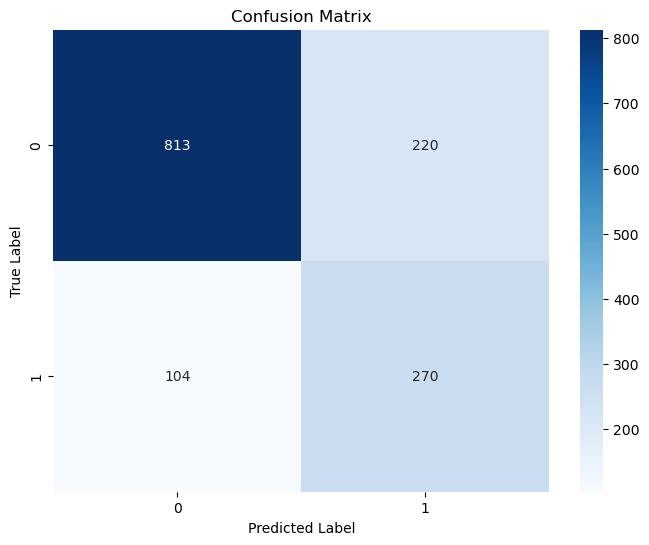

In [12]:

# Generate confusion matrix
y_pred = final_model.predict(test_df[features])
cm = confusion_matrix(test_df[target], y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



## 7. Feature Importance


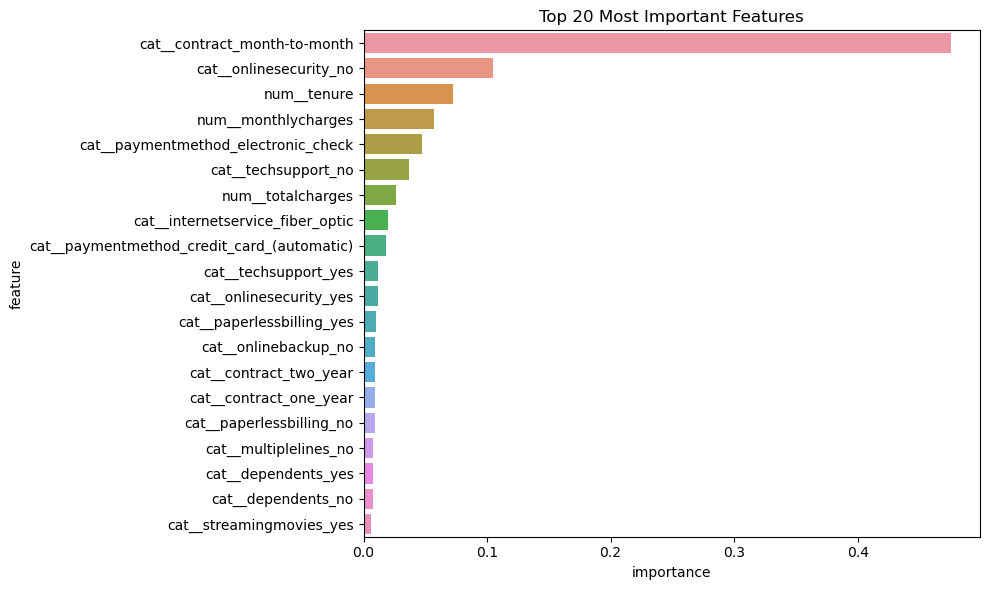

In [13]:

# If the final model supports feature importance (e.g., Random Forest)
if hasattr(final_model.named_steps['model'], 'feature_importances_'):
    importances = final_model.named_steps['model'].feature_importances_
    feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
    
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()



## 8. Conclusion and Next Steps


In [14]:

# Summarize findings
print("Model Performance Summary:")
print(f"Best Model: {type(final_model.named_steps['model']).__name__}")
print(f"Test Set Accuracy: {test_results['Accuracy']:.4f}")
print(f"Test Set F1 Score: {test_results['F1 Score']:.4f}")
print(f"Test Set AUC: {test_results['AUC']:.4f}")
    


Model Performance Summary:
Best Model: GradientBoostingClassifier
Test Set Accuracy: 0.7697
Test Set F1 Score: 0.6250
Test Set AUC: 0.8355


In [15]:
# Save the model
import pickle

# Save the model to a file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Model has been saved to 'best_model.pkl'")

Model has been saved to 'best_model.pkl'


In [16]:
# Load the model
with open('best_model.pkl', 'rb') as f:
    model = pickle.load(f)


# The code is loading a machine learning model from a file named 'best_model.pkl' using pickle. The loaded model is then stored in the variable `model`.
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHo...
                                                  Index(['partner', 'dependents', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            min_samples_leaf=4,
                                            n_estimators=300))])

In [23]:
import requests
import json

# The URL of your Flask API
url = 'http://localhost:5000/predict'

# Sample data for prediction
data = {
    "seniorcitizen": 0,
    "partner": "Yes",
    "dependents": "No",
    "tenure": 72,
    "multiplelines": "Yes",
    "internetservice": "Fiber optic",
    "onlinesecurity": "No",
    "onlinebackup": "Yes",
    "deviceprotection": "No",
    "techsupport": "No",
    "streamingtv": "Yes",
    "streamingmovies": "Yes",
    "contract": "Two year",
    "paperlessbilling": "Yes",
    "paymentmethod": "Bank transfer (automatic)",
    "monthlycharges": 99.65,
    "totalcharges": 7105.10
}

# Send POST request
response = requests.post(url, json=data)

# Print the response
print(response.status_code)
print(response.json())

200
{'prediction': 'No', 'probability': 0.10868846479067479}
